#**KerasClassifier**

In [ ]:
!pip install scikeras

In [11]:
import pandas as pd
import numpy as np
import tensorflow as tf
from keras import backend as k
import matplotlib.pyplot as plt
from keras.models import Sequential 
from keras.layers import Dense, Dropout
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder

In [13]:
df = pd.read_csv("advertising.csv")
df.head()

,Daily Time Spent on Site,Age,Area Income,Daily Internet Usage,Ad Topic Line,City,Male,Country,Timestamp,Clicked on Ad
0,68.95,35,61833.90,256.09,Cloned 5thgeneration orchestration,Wrightburgh,0,Tunisia,2016-03-27 00:53:11,0
1,80.23,31,68441.85,193.77,Monitored national standardization,West Jodi,1,Nauru,2016-04-04 01:39:02,0
2,69.47,26,59785.94,236.50,Organic bottom-line service-desk,Davidton,0,San Marino,2016-03-13 20:35:42,0
3,74.15,29,54806.18,245.89,Triple-buffered reciprocal time-frame,West Terrifurt,1,Italy,2016-01-10 02:31:19,0
4,68.37,35,73889.99,225.58,Robust logistical utilization,South Manuel,0,Iceland,2016-06-03 03:36:18,0


**Verificando se há dados nulos:**

In [10]:
df.isna().sum()

Daily Time Spent on Site    0
Age                         0
Area Income                 0
Daily Internet Usage        0
Ad Topic Line               0
City                        0
Male                        0
Country                     0
Timestamp                   0
Clicked on Ad               0
dtype: int64

In [21]:
df.head()

,Daily Time Spent on Site,Age,Area Income,Daily Internet Usage,Ad Topic Line,City,Male,Country,Timestamp,Clicked on Ad
0,0.249267,-0.114905,0.509691,1.734030,-1.415086,1.700304,0.962695,1.424572,-0.209578,0
1,0.961132,-0.570425,1.002530,0.313805,-0.122976,1.492546,-1.038750,0.451875,-0.088335,0
2,0.282083,-1.139826,0.356949,1.287589,0.230363,-1.344415,0.962695,0.981136,-0.458994,0
3,0.577432,-0.798185,-0.014456,1.501580,1.397766,1.621499,-1.038750,-0.177517,-1.536330,0
4,0.212664,-0.114905,1.408868,1.038731,0.923184,1.141508,0.962695,-0.277648,0.926648,0


**Transformando as Features categóricas em numéricas - OneHotEnconder - Features de dados binários:**

In [15]:
#"Male"
ohe =  OneHotEncoder(handle_unknown='ignore')
ohe.fit(df[["Male"]])

df["Male"] = ohe.transform(df[["Male"]]).toarray()

**Transformando as Features categóricas em numéricas - OrdinalEncoder() - Feature com mais de 2 classes.**

In [17]:
# "Ad Topic Line", "City", "Country", "Timestamp"
oe =  OrdinalEncoder()
oe.fit(df[["Ad Topic Line", "City", "Country", "Timestamp"]])

df[["Ad Topic Line", "City", "Country", "Timestamp"]] = oe.transform(df[["Ad Topic Line", "City", "Country", "Timestamp"]])

**Vamos escalonar todas as Features, pois a amplitude entre os dados está muito grande, transformar todas com média próximo de zero e desvio padrão próximo de 1**

In [19]:
df.columns

Index(['Daily Time Spent on Site', 'Age', 'Area Income',
       'Daily Internet Usage', 'Ad Topic Line', 'City', 'Male', 'Country',
       'Timestamp', 'Clicked on Ad'],
      dtype='object')

In [20]:
ssc = StandardScaler()

ssc.fit(df[['Daily Time Spent on Site', 'Age', 'Area Income','Daily Internet Usage', 'Ad Topic Line', 'City', 'Male', 'Country','Timestamp']])
h= ssc.transform(df[['Daily Time Spent on Site', 'Age', 'Area Income','Daily Internet Usage', 'Ad Topic Line', 'City', 'Male', 'Country','Timestamp']])
df[['Daily Time Spent on Site', 'Age', 'Area Income', 'Daily Internet Usage', 'Ad Topic Line', 'City', 'Male', 'Country','Timestamp']] = h

In [ ]:
df.columns

Index(['city', 'area', 'rooms', 'bathroom', 'parking spaces', 'floor',
       'animal', 'furniture', 'hoa (R$)', 'rent amount (R$)',
       'property tax (R$)', 'fire insurance (R$)', 'total (R$)'],
      dtype='object')

**Separando os dados em teste e treino:**

In [22]:
X = df.drop(columns=["Clicked on Ad"])
y = df["Clicked on Ad"]

In [23]:
def criarRede(optimizer='rmsprop', init='glorot_uniform'):
    k.clear_session()
    rn = Sequential([
                #1ª camada oculta
               tf.keras.layers.Dense(units=5, activation = "relu", kernel_initializer = "random_uniform", input_dim=9), # input_dim = nº de colunas
               tf.keras.layers.Dropout(0.2),
               #2ª camada oculta
               tf.keras.layers.Dense(units=5, activation = "relu", kernel_initializer = "random_uniform"),
               tf.keras.layers.Dropout(0.2), #Dropout = % de colunas zeradas para não dar overfitting! Recomendável entre 0.2 e 0.3
               #3ª camada oculta
               tf.keras.layers.Dense(units=5, activation = "relu", kernel_initializer = "random_uniform"),
               tf.keras.layers.Dropout(0.2), #Dropout = % de colunas zeradas para não dar overfitting! Recomendável entre 0.2 e 0.3
               #4º camada oculta
               tf.keras.layers.Dense(units=5, activation = "relu", kernel_initializer = "random_uniform"),
               tf.keras.layers.Dropout(0.2), #Dropout = % de colunas zeradas para não dar overfitting! Recomendável entre 0.2 e 0.3
               #Camada de saída
               tf.keras.layers.Dense(units= 1, activation = 'sigmoid')])
    

    rn.compile(optimizer = optimizer, loss = "binary_crossentropy", metrics = ['binary_accuracy'])


    return rn

In [ ]:
rn = KerasClassifier(model=criarRede)
#============================================================================================
optimizers = ['rmsprop', 'adam']
init = ['glorot_uniform', 'normal', 'uniform']
epochs = [50, 100, 150]
batches = [5, 10, 20]
param_grid = dict(optimizer=optimizers, epochs=epochs, batch_size=batches, model__init=init)

#================================================================================
grid_search = GridSearchCV(estimator=rn,
                           param_grid=param_grid,
                           scoring="accuracy",
                           cv=5)

grid_search_bc = grid_search.fit(X, y)

**Salvar o modelo:**

In [25]:
import pickle

In [26]:
with open("grid_search_bc.pkl", "wb") as f:
    pickle.dump(grid_search_bc, f)

In [ ]:
with open("grid_search_bc.pkl", "rb") as f:
    
    grid_search_bc = pickle.load(f)

In [27]:
grid_search_bc.best_params_

{'batch_size': 20, 'epochs': 50, 'model__init': 'normal', 'optimizer': 'adam'}

**Score:**

In [52]:
print(f"O melhor score foi de {(grid_search_bc.best_score_)*100:.2f}%")

O melhor score foi de 97.10%


Superamos o XGBoost e Otimização Bayesiana


Métricas de avaliação de treino:
50/50 [==============================] - 0s 1ms/step
[[492   8]
 [ 20 480]]


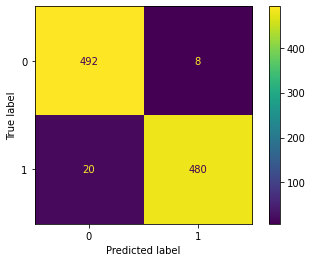

              precision    recall  f1-score   support

           0       0.96      0.98      0.97       500
           1       0.98      0.96      0.97       500

    accuracy                           0.97      1000
   macro avg       0.97      0.97      0.97      1000
weighted avg       0.97      0.97      0.97      1000


Métricas de avaliação de teste:
50/50 [==============================] - 0s 1ms/step
[[492   8]
 [ 20 480]]


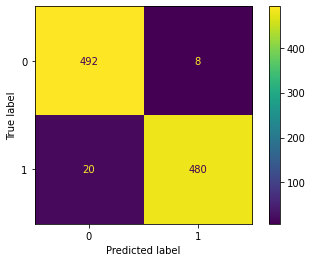

              precision    recall  f1-score   support

           0       0.96      0.98      0.97       500
           1       0.98      0.96      0.97       500

    accuracy                           0.97      1000
   macro avg       0.97      0.97      0.97      1000
weighted avg       0.97      0.97      0.97      1000



In [48]:
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

# ============================================

print("\nMétricas de avaliação de treino:")

y_pred_train = grid_search_bc.predict(X)

print(confusion_matrix(y, y_pred_train))

ConfusionMatrixDisplay.from_predictions(y, y_pred_train)
plt.show()

print(classification_report(y, y_pred_train))

# ============================================

print("\nMétricas de avaliação de teste:")

y_pred_test = grid_search_bc.predict(X)

print(confusion_matrix(y, y_pred_test))

ConfusionMatrixDisplay.from_predictions(y, y_pred_test)
plt.show()

print(classification_report(y, y_pred_test))

In [37]:
tabela = pd.DataFrame()
tabela["y real"] = y
tabela["y preditivo"] = y_pred_test
tabela

,y real,y preditivo
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0
...,...,...
995,1,0
996,1,1
997,1,1
998,0,1


Salvando a tabela...

In [54]:
tabela.to_csv("tabela_comparação.csv")

In [47]:
lista = []
for c in range(tabela.shape[0]):
  if tabela.loc[[c]].values[0][1] != tabela.loc[[c]].values[0][0]:
      valor = 0
      lista.append(valor)
  elif tabela.loc[[c]].values[0][1] == tabela.loc[[c]].values[0][0]:
      valor = 100
      lista.append(valor)
media = np.mean(lista)
print(f"Teve uma média de acerto de {media:.2f}%")

Teve uma média de acerto de 97.20%


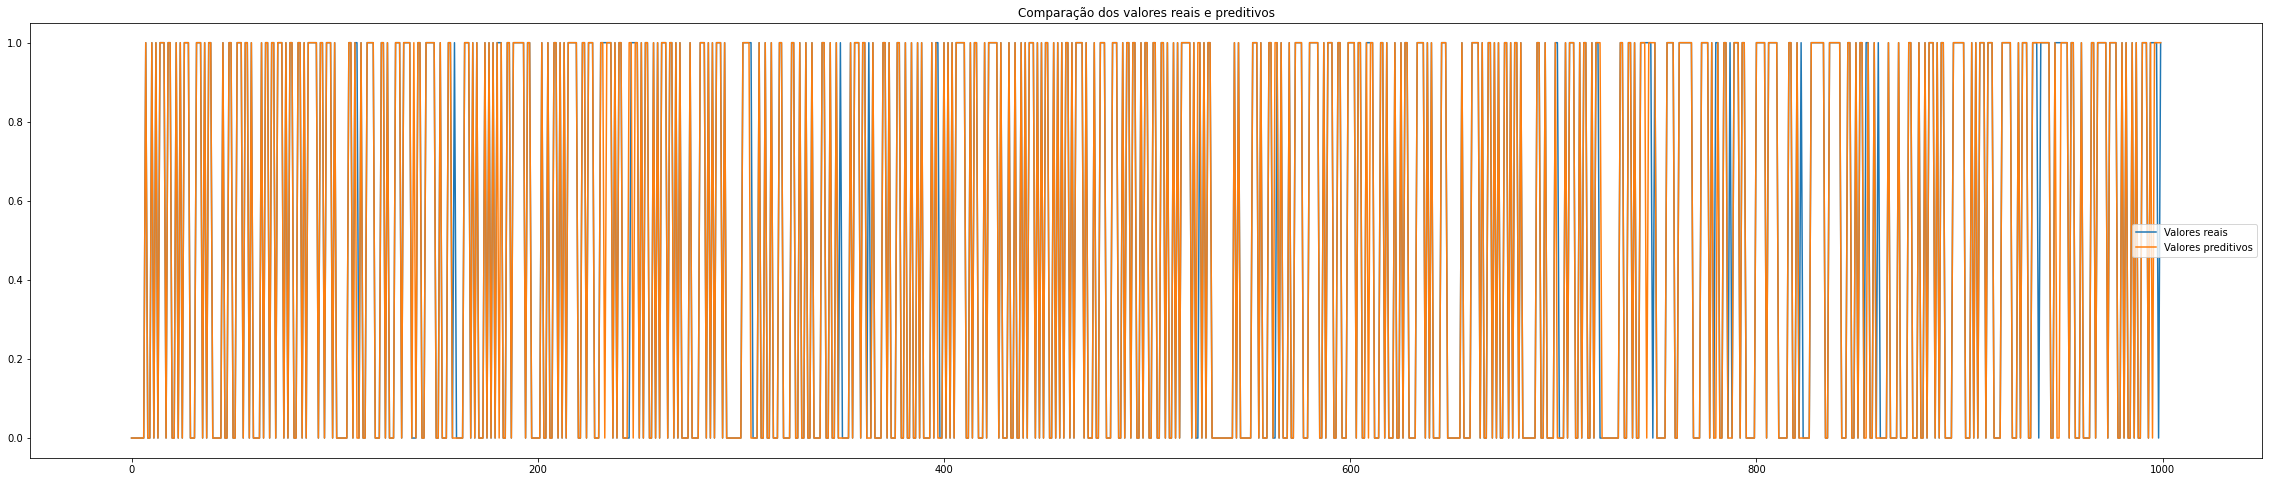

In [53]:
plt.figure(figsize=(40,8))
x_ax = range(len(y))
plt.plot(x_ax, y, label="Valores reais")
plt.plot(x_ax, y_pred_test, label="Valores preditivos")
plt.title("Comparação dos valores reais e preditivos")
plt.legend()
plt.show();